In [ ]:
! sudo apt install tesseract-ocr-eng
! pip install pytesseract
! pip install pdf2image
! pip install docx2txt
! sudo apt-get install -y poppler-utils
! pip install torchmetrics

In [ ]:
# импорты
import pytesseract
from PIL import Image
import os
import random
from pdf2image import convert_from_path
import numpy as np
import torch
import torchmetrics

Данные

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
!mkdir '/content/KK-BOOKS-1971'
!mkdir '/content/KK-BOOKS-2006'
!mkdir '/content/KK-BOOKS-1971-texts'

In [ ]:
for file in os.listdir('/content'):
  if file.endswith('.pdf'):

    filepath = f'/content/{file}'
    doc = convert_from_path(filepath)
  
    folder_name = "-".join(file.split('-')[:3])
    for i in range(len(doc)):
      doc[i].save(f'/content/{folder_name}/image_{i+1}.png', 'PNG')

  elif file.endswith('.txt'):
    os.system(f'mv /content/{file} /content/KK-BOOKS-1971-texts')

Попробуем использовать импортированную модель для распознания данных на нама

In [ ]:
recognised_text = []
images_path = '/content/KK-BOOKS-1971'
for img in os.listdir(images_path):
  img = Image.open(f'{images_path}/{img}')
  text = pytesseract.image_to_string(img, lang='eng')
  recognised_text.append(text)

In [ ]:
# посмотрим на эффективность работы модели
cer = torchmetrics.CharErrorRate()

original_text = []
texts_path = '/content/KK-BOOKS-1971-texts'
for t in os.listdir(texts_path):
  if t.endswith('.txt'):
    with open(f'{texts_path}/{t}', 'r') as file:
        text = file.read()
        original_text.append(text)

model_result = cer(original_text, recognised_text)

In [ ]:
print(f"CER: {model_result}")
print(f"Accuracy: {1 - model_result}")

CER: 3.7874069213867188
Accuracy: -2.7874069213867188


Модель практически ничего не распознает

 ### Предварительная обработка данных

In [ ]:
# бинаризация
import matplotlib.pyplot as plt
from skimage import io, color, filters

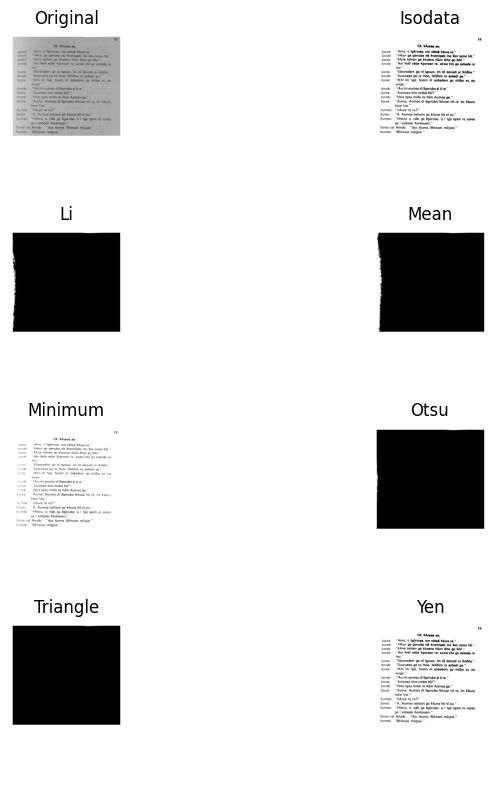

In [ ]:
from skimage.filters import try_all_threshold

img = io.imread('/content/KK-BOOKS-1971/image_10.png')
gray_img = color.rgb2gray(img)

fig, ax = try_all_threshold(gray_img, figsize=(10, 8), verbose=False)
plt.show()

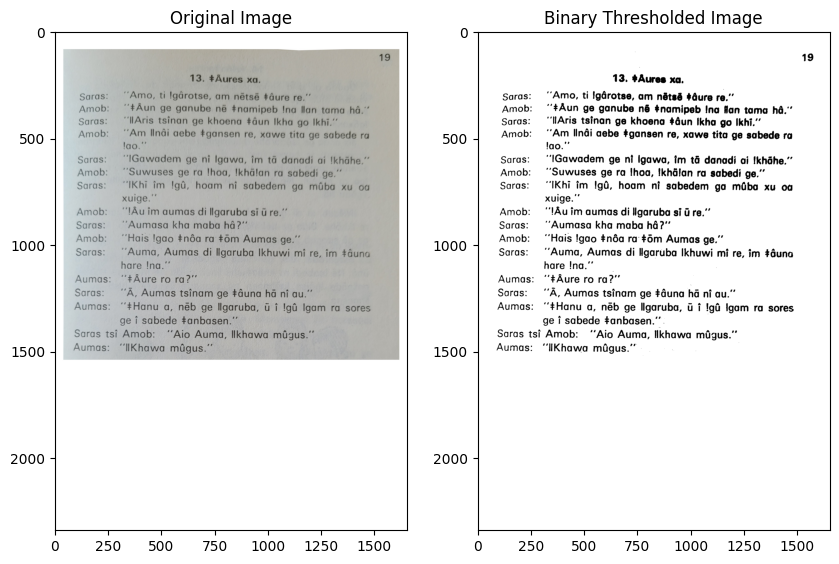

In [ ]:
# оптимальный вариант
from skimage.filters import threshold_yen

threshold_value = filters.threshold_yen(gray_img)
binary_img = gray_img > threshold_value

fig, ax = plt.subplots(ncols=2, figsize=(10, 8))
ax[0].imshow(img)
ax[0].set_title('Original Image')
ax[1].imshow(binary_img, cmap='gray')
ax[1].set_title('Binary Thresholded Image')
plt.show()

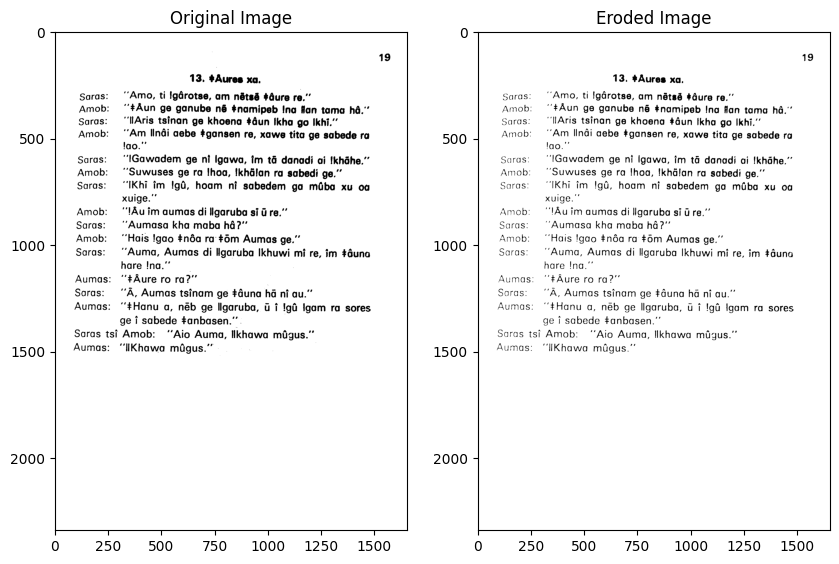

In [ ]:
# dilation
from skimage import morphology

# Define structuring element
selem = morphology.disk(1)

# Apply erosion
eroded_img = morphology.dilation(binary_img, selem)

# Display output
fig, ax = plt.subplots(ncols=2, figsize=(10, 8))
ax[0].imshow(binary_img, cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(eroded_img, cmap='gray')
ax[1].set_title('Eroded Image')
plt.show()

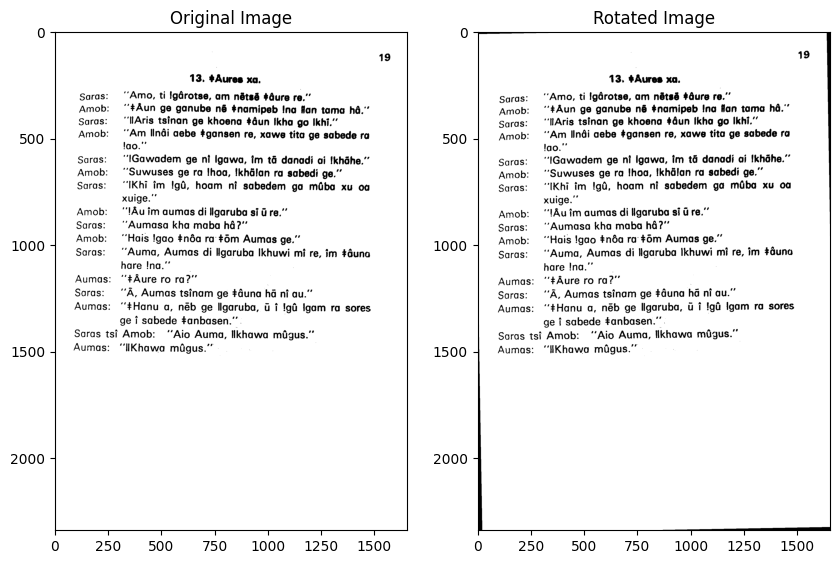

In [ ]:
# deskewing
from skimage import transform

# Define rotation angle
angle = 1

# Apply rotation
rotated_img = transform.rotate(binary_img, angle)

# Display output
fig, ax = plt.subplots(ncols=2, figsize=(10, 8))
ax[0].imshow(binary_img, cmap='gray')
ax[0].set_title('Original Image')``

In [ ]:
# Попробуем распознать данные

rt_after_preprocessing = []
images_path = '/content/KK-BOOKS-1971'
for img in os.listdir(images_path):
  img = io.imread(f'{images_path}/{img}')
  gray_img = color.rgb2gray(img)
  
  threshold_value = filters.threshold_yen(gray_img)
  binary_img = gray_img > threshold_value

  eroded_img = morphology.dilation(binary_img, selem)
  rotated_img = transform.rotate(eroded_img, angle)

  text = pytesseract.image_to_string(rotated_img, lang='eng')
  rt_after_preprocessing.append(text)

In [ ]:
model_result_2 = cer(original_text, rt_after_preprocessing)

In [ ]:
print(f"CER: {model_result_2}")
print(f"Accuracy: {1 - model_result_2}")

CER: 0.9417584538459778
Accuracy: 0.05824154615402222


Гораздо лучше, чем без предварительной обработки изображений, но всё ещё очень плохо

### Fine-tuning (не доделано)

In [ ]:
!sudo apt-get install libicu-dev libpango1.0-dev libcairo2-dev

In [ ]:
# создаем данные
files = ['/content/KK-BOOKS-1979-Khomai3.docx',
         '/content/KK-BOOKS-1972-Khomai2.docx',
         '/content/KK-BOOKS-1971-Khomai.docx']

In [ ]:
text_number = 1
for file in files:
  text = docx2txt.process(file)
  text = text.split('.')
  for t in text:
    with open(f'/content/texts/{text_number}.txt', 'w') as f:
      f.write(t)
    text_number += 1

In [ ]:
#устанавливаем шрифты
from google.colab import files
uploaded = files.upload()

Saving Arimo.zip to Arimo.zip


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Tinos.zip to Tinos.zip


In [ ]:
!mkdir /content/Arimo # arial
!mkdir /content/Tinos # times new roman

In [ ]:
!mv /content/Arimo.zip /content/Arimo
!mv /content/Tinos.zip /content/Tinos

In [ ]:
!mv /content/Arimo /usr/share/fonts/truetype
!mv /content/Tinos /usr/share/fonts/truetype

In [ ]:
!fc-cache -f -v

/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 4 dirs
/usr/share/fonts/truetype/Arimo: caching, new cache contents: 8 fonts, 0 dirs
/usr/share/fonts/truetype/Tinos: caching, new cache contents: 4 fonts, 0 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/Arimo: skipping, looped directory detected
/usr/share/fonts/truetype/Tinos: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/var/cache/fontconfig: clean

In [ ]:
!mkdir /content/training_data

In [ ]:
counter = 1
for t in os.listdir('/content/texts'):
  if t[-4:] == '.txt':
    os.system(f'text2image --text /content/texts/{t} --outputbase /content/training_data/{counter}  --font Arimo --fonts_dir /usr/share/fonts')
    counter += 1
    os.system(f'text2image --text /content/texts/{t} --outputbase /content/training_data/{counter}  --font Tinos --fonts_dir /usr/share/fonts')
    counter += 1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /content/training_data /content/drive/MyDrive/NAMA_OCR

In [ ]:
!cp -r /content/texts /content/drive/MyDrive/NAMA_OCR

In [ ]:
!git clone https://github.com/tesseract-ocr/tessdata_best

Cloning into 'tessdata_best'...
remote: Enumerating objects: 254, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 254 (delta 0), reused 2 (delta 0), pack-reused 250
Receiving objects: 100% (254/254), 1.30 GiB | 20.63 MiB/s, done.
Resolving deltas: 100% (41/41), done.
Updating files: 100% (167/167), done.


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving eng.unicharset to eng.unicharset


In [ ]:
!combine_lang_model --input_unicharset /path/to/unicharset \
--script_dir /path/to/script_dir --output_dir /path/to/output_dir \
--lang nama --version 1 --model_name naq

In [ ]:
! training/lstmtraining --model_output /content/naq \
  --continue_from /content/tessdata_best/eng.traineddata \
  --traineddata /path/to/original/traineddata \
  --train_listfile /path/to/list/of/filenames.txt \
  --max_iterations 400

NameError: ignored